## 목차
1. 데이터 준비  
    [1-1. 라이브러리 불러오기](#라이브러리-불러오기)  
    [1-2. 데이터 불러오기](#데이터-불러오기)  
2. 전처리  
    [2-1. 결측치 식별](#결측치-식별)  
    [2-2. 타입 변경](#타입-변경)  
    [2-3. 이상치 식별](#이상치-식별)  
    [2-4. 이상치 필터링](#이상치-필터링price)  
    [2-5. 카테고리 통일](#카테고리-통일)  
3. EDA  
    [3-1. 플랫폼 EDA](#platform-분포)  
    [3-2. Post time EDA](#플랫폼-별-post_time)  
    [3-3. title EDA](#title)  
    [3-4. 연속형 변수 EDA](#연속형-변수price-view_count-like_count-통계치-확인)  
    [3-5. 판매자 위치 EDA](#seller_location)  
    [3-6. Status EDA](#status)  
4. 데이터 저장  
    [4. 필터링 데이터 저장](#필터-데이터프레임-저장pickle_data)  

### 라이브러리 불러오기

In [241]:
# 라이브러리 불러오기기
import pandas as pd
import matplotlib.pyplot as plt
import openai
import json
import os
from dotenv import load_dotenv
from konlpy.tag import Okt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import missingno as msno


In [242]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

### 데이터 불러오기

In [231]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')

In [238]:
data_file_path = os.path.join(data_directory, '오픈마켓 노쇼핑 샘플 데이터.xlsx')
sample_df = pd.read_excel(data_file_path)

In [239]:
sample_df.head()

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,seller_location,expiration_date,market_price,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,당근마켓,https://www.daangn.com/articles/836464147,2024-10-02 12:54:31.443000,호텔 양도,664,11,"11,111원",https://img.kr.gcp-karroter.net/origin/article...,"1. 횡성 웰리힐리파크리조트 \n- 10월 3일, 4일, 5일 패밀리룸 (15만원)...",티켓/교환권,...,연수구 송도3동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,당근마켓,https://www.daangn.com/articles/832373103,2024-10-02 12:53:31.443000,속초 체스터톤스 호텔,310,7,"170,000원",https://img.kr.gcp-karroter.net/origin/article...,속초 체스터톤스 숙박권입니다.\n3매구요~\n원하는 매수 만큼 가능하세요.\n투룸 ...,티켓/교환권,...,부천시 여월동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,당근마켓,https://www.daangn.com/articles/840996796,2024-10-02 12:52:31.443000,수성호텔 vip 티켓 1장,4,0,"34,000원",https://img.kr.gcp-karroter.net/origin/article...,"수성호텔 호텔수성 vip 티켓 (수영장,루프탑,인피니티풀, 온천, 사우나, 이벤트...",티켓/교환권,...,북구 매천동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,당근마켓,https://www.daangn.com/articles/840996718,2024-10-02 12:52:31.443000,코엑스 주차권 (유효기간없음),11,1,"5,000원",https://img.kr.gcp-karroter.net/origin/article...,코엑스 5시간 주차권입니다.\n(원래 코엑스 기본 주차요금 1시간 6000원) \n...,티켓/교환권,...,강남구 개포동,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   platform              921 non-null    object
 1   original_link         921 non-null    object
 2   post_time             921 non-null    object
 3   title                 921 non-null    object
 4   view_count            921 non-null    object
 5   like_count            921 non-null    object
 6   price                 921 non-null    object
 7   images                917 non-null    object
 8   description           921 non-null    object
 9   category              422 non-null    object
 10  status                422 non-null    object
 11  seller_location       272 non-null    object
 12  expiration_date       1 non-null      object
 13  market_price          1 non-null      object
 14  capacity              1 non-null      object
 15  parking               1 non-null      ob

In [147]:
# 필요한(사용 가능한) 필드만 추출
sample_df = sample_df.iloc[:,0:12]

### 결측치 식별

In [148]:
sample_df.isnull().sum()

platform             4
original_link        4
post_time            4
title                4
view_count           4
like_count           4
price                4
images               8
description          4
category           503
status             503
seller_location    653
dtype: int64

<Axes: >

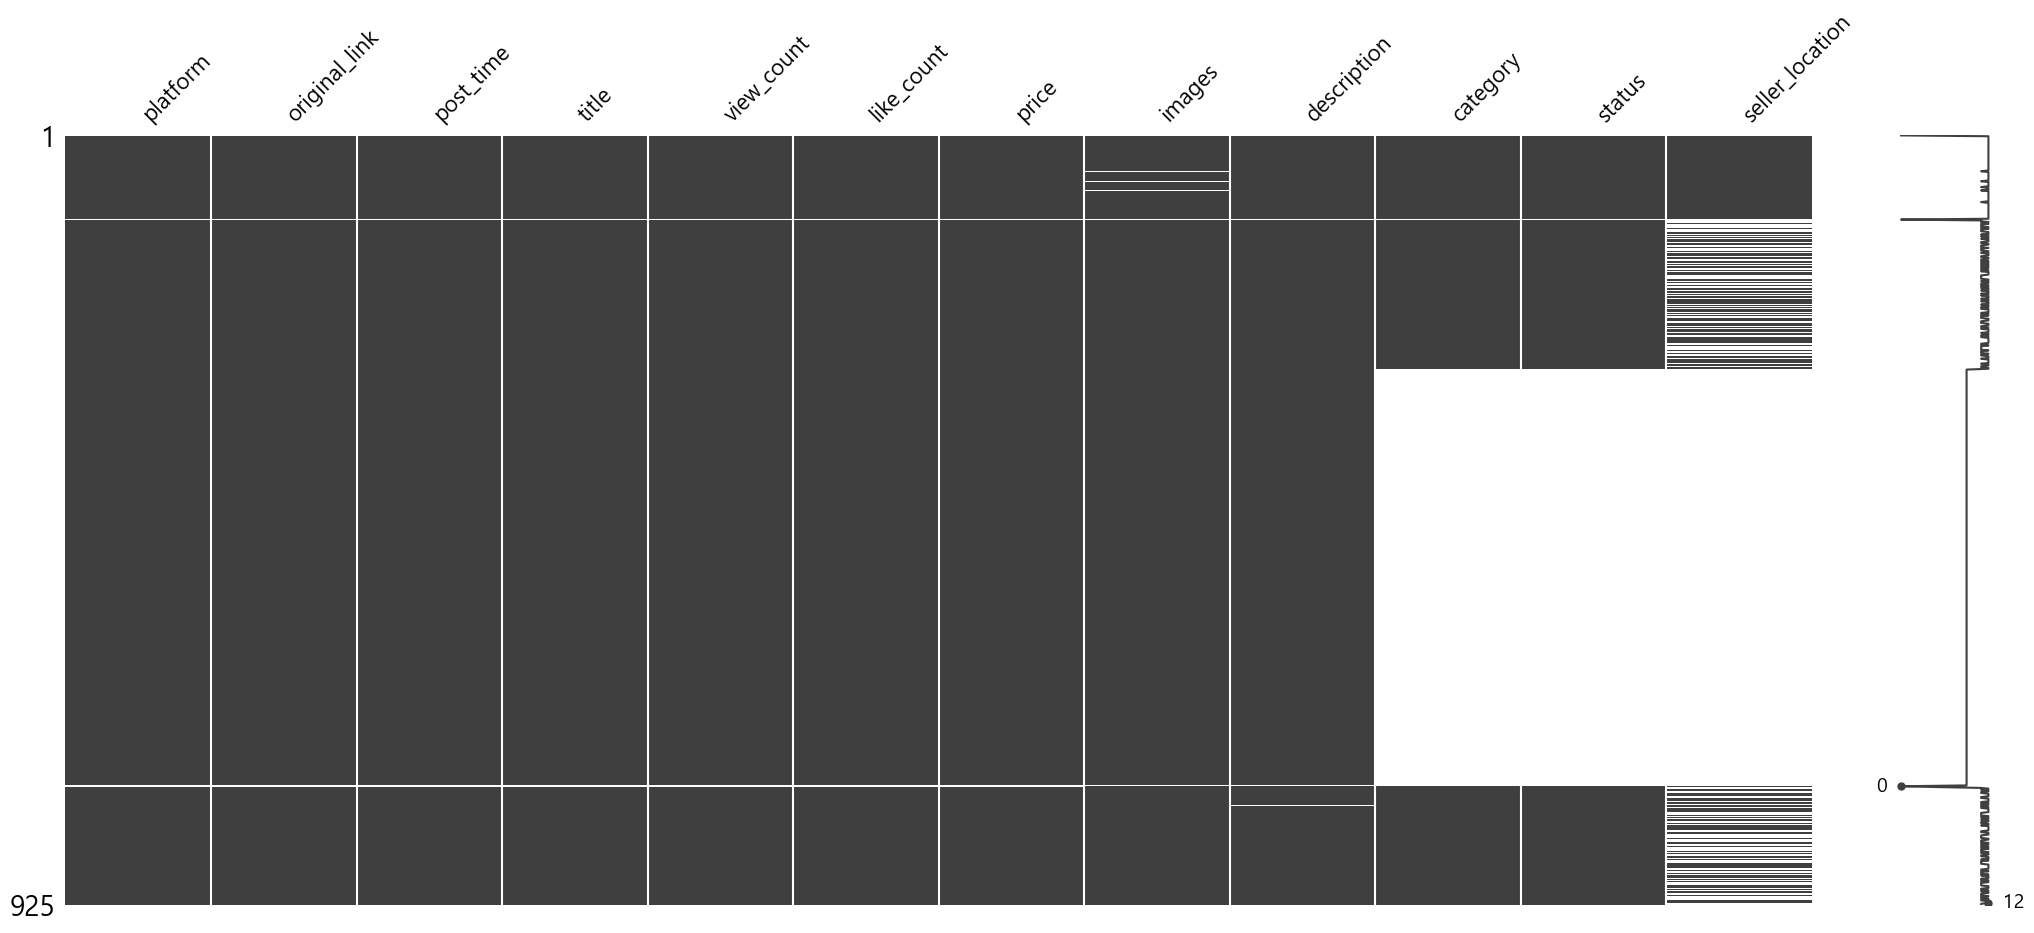

In [150]:
msno.matrix(sample_df)

특정 플랫폼에서 카테고리, status, 판매자_지역 정보가 통쨰로 없음

In [151]:
# 특정 4개 열 삭제(크롤링 단계에서 플랫폼 별 구분을 위해 빈 행을 집어넣음 -> 삭제)
sample_df.dropna(subset=['platform'],inplace=True)
sample_df.reset_index(drop=True, inplace=True)

### 타입 변경

In [152]:
# price 필드 포맷 통일 후 타입 변경
sample_df['price'] = sample_df['price'].astype(str)
sample_df['price'] = sample_df['price'].str.replace(',','')\
                                        .str.replace('만원','0000')\
                                        .str.replace('만','')\
                                        .str.replace('원','')\
                                        .str.replace(' ','').astype(int)
# view_count 필드 포맷 통일 후 타입 변경
sample_df['view_count'] = sample_df['view_count'].astype(str)
sample_df['view_count'] = sample_df['view_count'].str.replace('조회 ', '').astype(int)
# like_count 필드 포맷 통일 후 타입 변경
sample_df['like_count'] = sample_df['like_count'].astype(str)
sample_df['like_count'] = sample_df['like_count'].str.replace('시세조회', '').astype(int)
# post_time date형식으로 타입 변경
sample_df['post_time'] = pd.to_datetime(sample_df['post_time'])

In [154]:
# 중복 행 제거
sample_df.drop_duplicates(inplace=True)

In [155]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 918 entries, 0 to 920
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   platform         918 non-null    object        
 1   original_link    918 non-null    object        
 2   post_time        918 non-null    datetime64[ns]
 3   title            918 non-null    object        
 4   view_count       918 non-null    int32         
 5   like_count       918 non-null    int32         
 6   price            918 non-null    int32         
 7   images           913 non-null    object        
 8   description      917 non-null    object        
 9   category         421 non-null    object        
 10  status           421 non-null    object        
 11  seller_location  271 non-null    object        
dtypes: datetime64[ns](1), int32(3), object(8)
memory usage: 82.5+ KB


### 이상치 식별

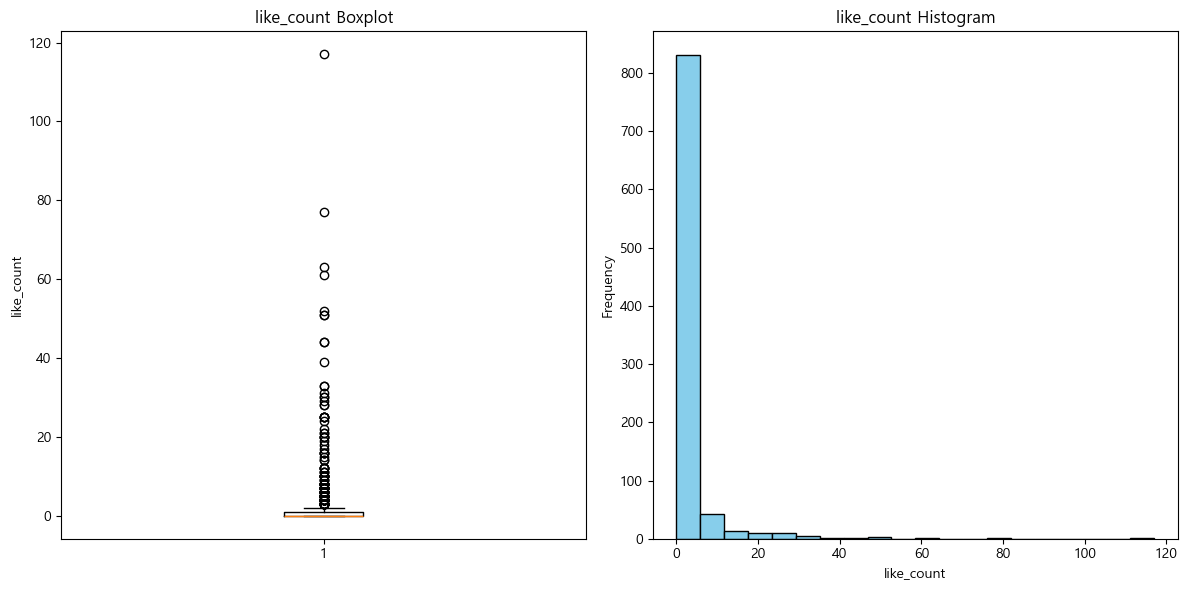

In [156]:
# like_count에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(sample_df['like_count'])
axes[0].set_title('like_count Boxplot')
axes[0].set_ylabel('like_count')

axes[1].hist(sample_df['like_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('like_count Histogram')
axes[1].set_xlabel('like_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

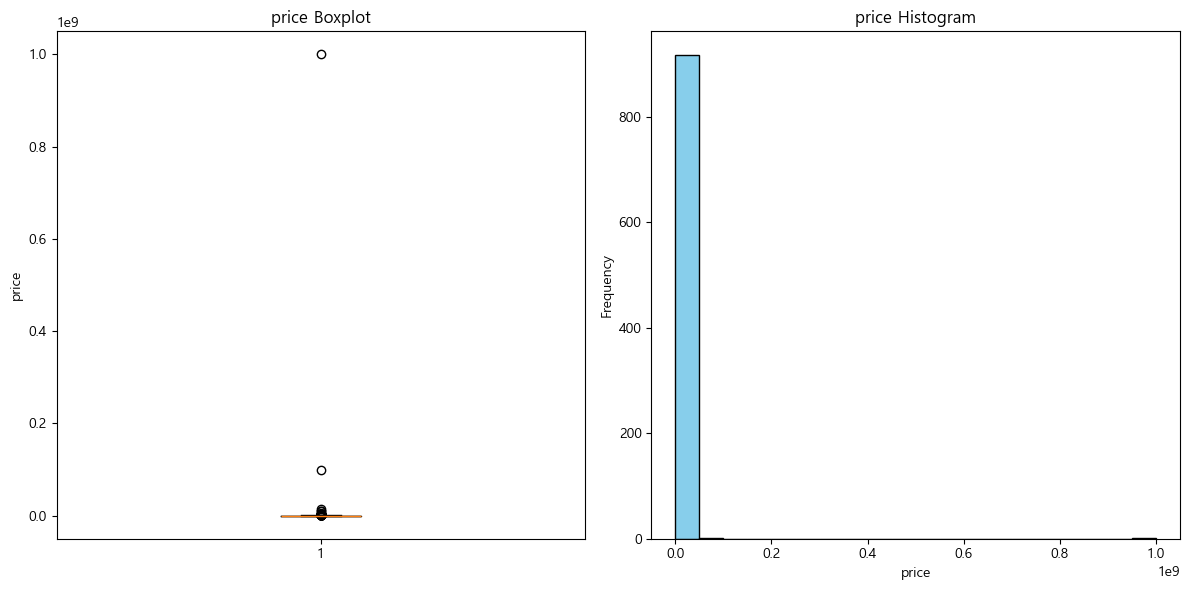

In [157]:
# price에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(sample_df['price'])
axes[0].set_title('price Boxplot')
axes[0].set_ylabel('price')

axes[1].hist(sample_df['price'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('price Histogram')
axes[1].set_xlabel('price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

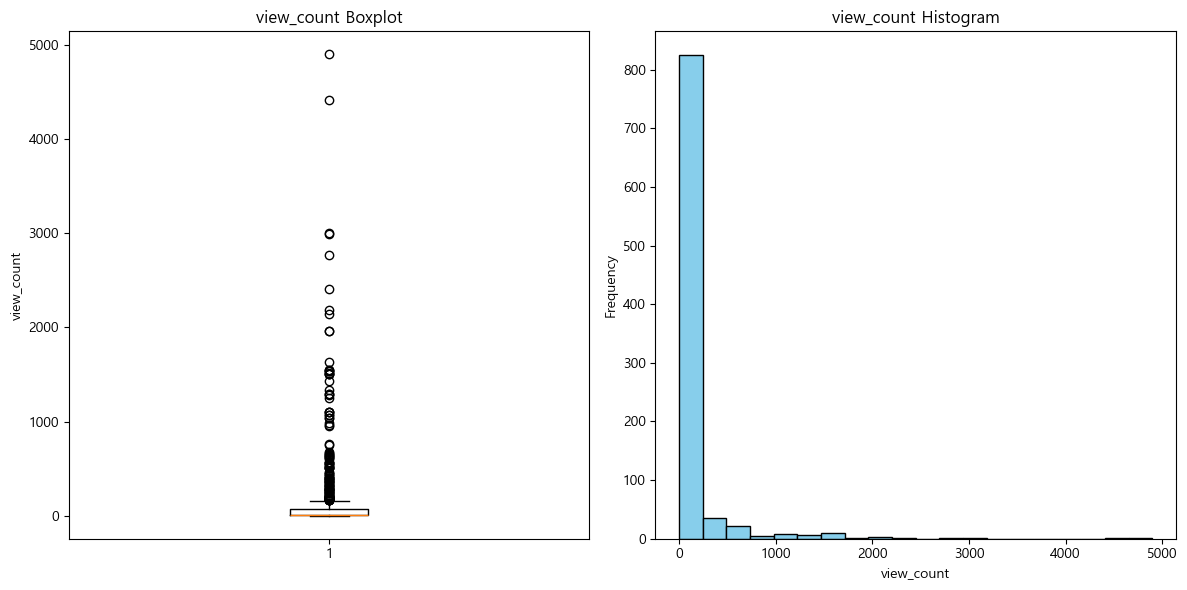

In [158]:
# view_count에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(sample_df['view_count'])
axes[0].set_title('view_count Boxplot')
axes[0].set_ylabel('view_count')

axes[1].hist(sample_df['view_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('view_count Histogram')
axes[1].set_xlabel('view_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 이상치 필터링(price)

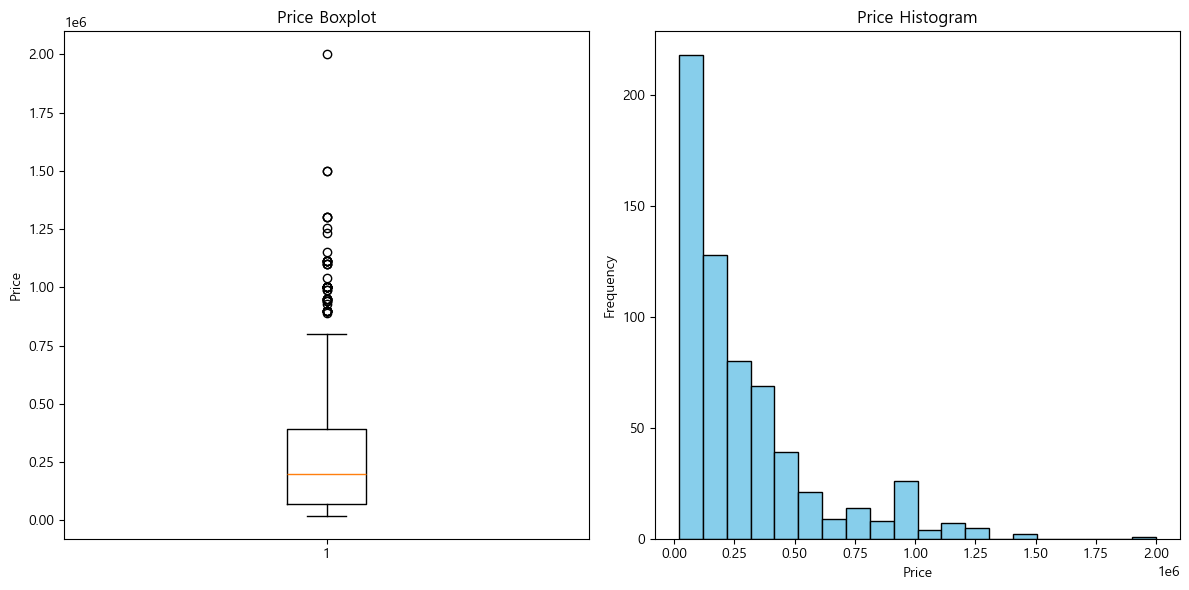

In [169]:
# 필터링된 price에 대한 박스플롯 및 히스토그램(2만원 이상 2백만원 이하)
filter_df = sample_df[(sample_df['price']>=20000)&(sample_df['price']<=2000000)]
filter_df.reset_index(drop=True,inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].boxplot(filter_df['price'])
axes[0].set_title('Price Boxplot')
axes[0].set_ylabel('Price')

axes[1].hist(filter_df['price'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('Price Histogram')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 카테고리 통일

In [188]:
filter_df['category'].value_counts()

category
여행/숙박/렌트       223
티켓/교환권          61
외식              28
생활/주방           10
가구/인테리어          8
콘서트              7
테마파크             5
만화               3
기타(상품권)          3
뷰티/미용            1
스포츠/레저           1
여성의류             1
취미/게임/음반         1
도서               1
기타(티켓)           1
가공식품             1
학습/사전/참고서        1
경제/경영            1
여행/취미/레저/건강      1
학습도구/문구/필기류      1
시/소설             1
Name: count, dtype: int64

카테고리 필터링 : 여행/숙박/렌트, 티켓/교환권, NAN(중고나라는 카테고리 기준으로 크롤링)

In [190]:
filter_df = filter_df[(filter_df['category'] =='여행/숙박/렌트')|(filter_df['category'] =='티켓/교환권')|(filter_df['category'].isnull())]
filter_df.reset_index(drop=True, inplace=True)

### Platform 분포

In [199]:
filter_df['platform'].value_counts()

platform
중고나라    271
번개장터    223
당근마켓     61
Name: count, dtype: int64

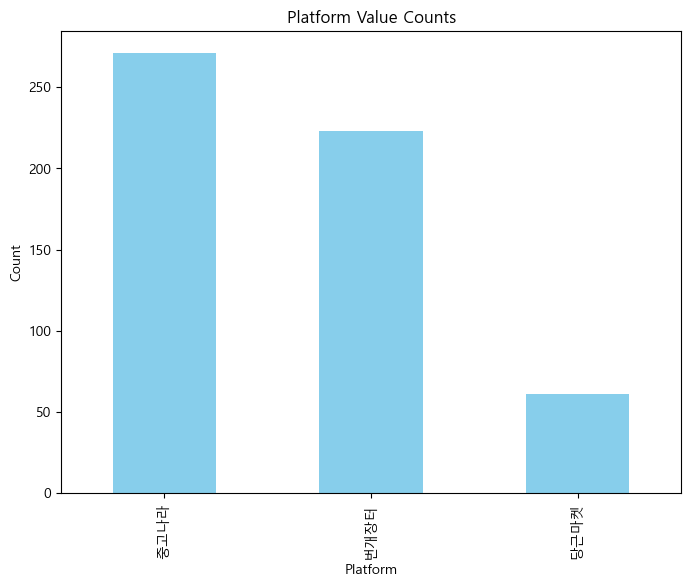

In [200]:
platform_counts = filter_df['platform'].value_counts()

plt.figure(figsize=(8, 6))
platform_counts.plot(kind='bar', color='skyblue')

plt.title('Platform Value Counts')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.show()

### 플랫폼 별 Post_time

In [201]:
filter_df['post_time']

0     2024-10-02 12:53:31.443
1     2024-10-02 12:52:31.443
2     2024-10-02 12:52:31.443
3     2024-10-02 12:35:31.443
4     2024-10-02 12:33:31.443
                ...          
550   2024-09-28 16:38:37.343
551   2024-10-04 12:38:37.343
552   2024-09-20 16:38:37.343
553   2024-09-25 16:38:37.343
554   2024-09-21 16:38:37.343
Name: post_time, Length: 555, dtype: datetime64[ns]

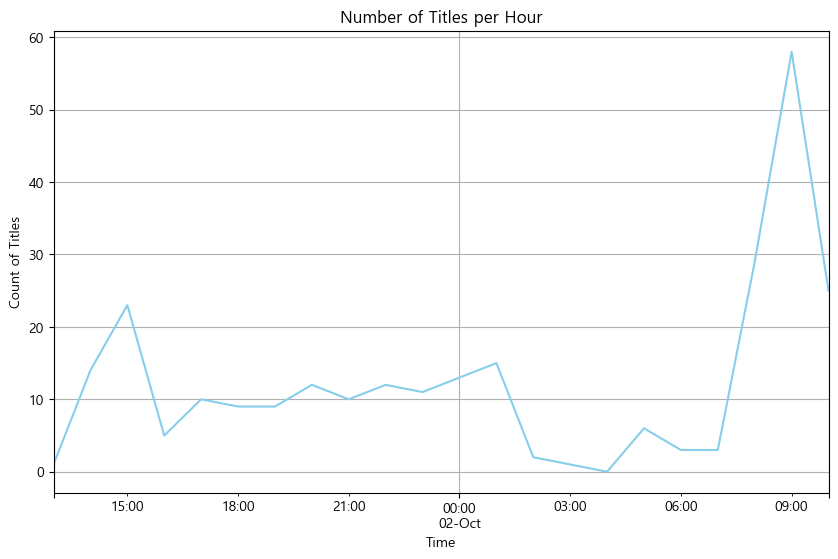

In [202]:
joongn_df = filter_df[filter_df['platform']=='중고나라']
title_counts = joongn_df.resample('H', on='post_time')['title'].count()

plt.figure(figsize=(10, 6))
title_counts.plot(kind='line', color='skyblue')

plt.title('Number of Titles per Hour')
plt.xlabel('Time')
plt.ylabel('Count of Titles')

plt.grid(True)
plt.show()

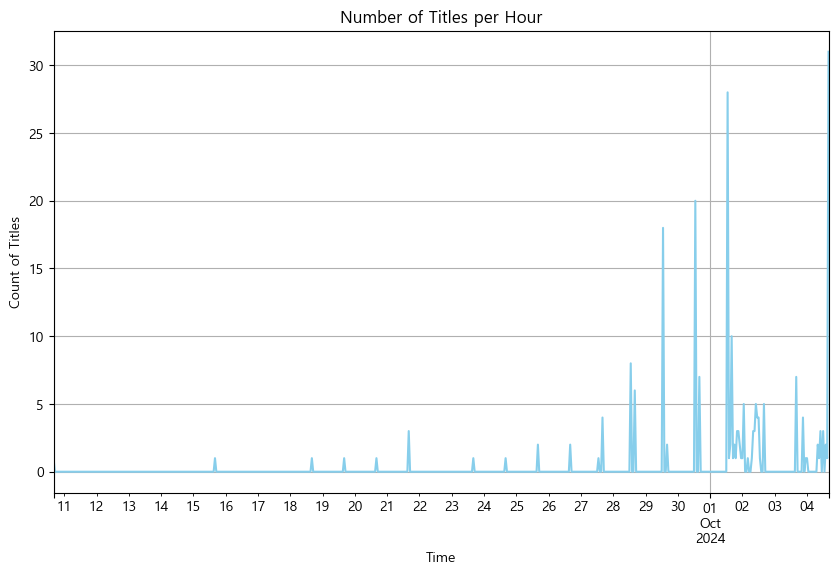

In [203]:
bunjang_df = filter_df[filter_df['platform']=='번개장터']
title_counts = bunjang_df.resample('H', on='post_time')['title'].count()

plt.figure(figsize=(10, 6))
title_counts.plot(kind='line', color='skyblue')

plt.title('Number of Titles per Hour')
plt.xlabel('Time')
plt.ylabel('Count of Titles')

plt.grid(True)
plt.show()

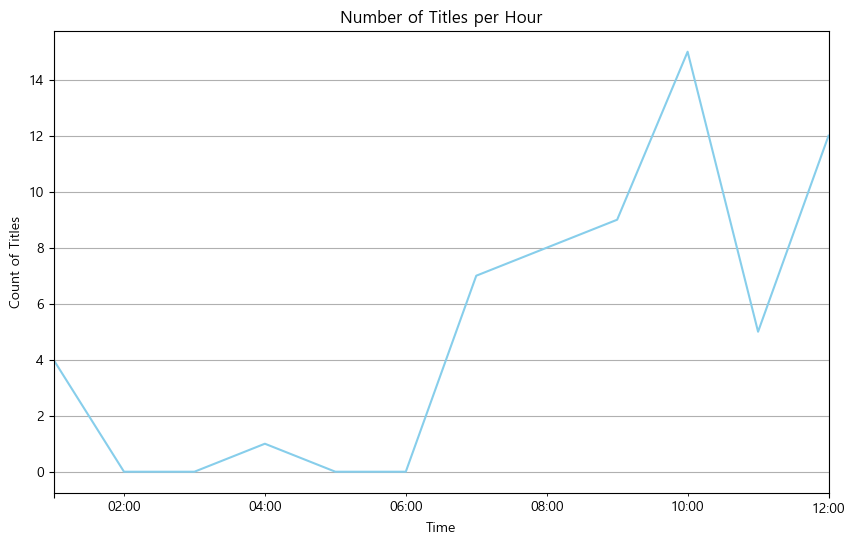

In [204]:
daangn_df = filter_df[filter_df['platform']=='당근마켓']
title_counts = daangn_df.resample('H', on='post_time')['title'].count()

plt.figure(figsize=(10, 6))
title_counts.plot(kind='line', color='skyblue')

plt.title('Number of Titles per Hour')
plt.xlabel('Time')
plt.ylabel('Count of Titles')

plt.grid(True)
plt.show()

### title

In [205]:
from konlpy.tag import Okt

In [206]:
# test
okt = Okt()

okt.nouns(filter_df['title'][0])

['속초', '체스터', '톤스', '호텔']

In [207]:
# 멀티쓰레딩 오류 뜸(BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore)
# from concurrent.futures import ProcessPoolExecutor

# def extract_nouns(text):
#     return okt.nouns(text)

# with ProcessPoolExecutor() as executor:
#     sample_df['title_nouns'] = list(executor.map(extract_nouns, sample_df['title']))


In [208]:
filter_df['title_nouns'] = [okt.nouns(title) for title in tqdm(filter_df['title'])]

100%|██████████| 555/555 [00:01<00:00, 335.35it/s]


In [209]:
filter_df['title_nouns']

0                                     [속초, 체스터, 톤스, 호텔]
1                                       [수성, 호텔, 티켓, 장]
2      [아난, 티, 리조트, 호텔, 가평, 코브, 빌라, 쥬드, 남해, 제주, 숙박, 양도]
3                                 [파타야, 힐튼, 호텔, 디럭스, 룸]
4                                          [글램, 호텔, 숙박]
                             ...                       
550                               [스위스, 그랜드, 호텔, 서울, 박]
551                      [가격, 일본, 도쿄, 호텔, 아사쿠사, 숙소, 양도]
552                                 [이탈리아, 베니스, 호텔, 숙박]
553                     [조선, 호텔, 롯데, 호텔, 숙박, 및, 양도, 구매]
554                     [상하, 농원, 파머스빌리, 호텔, 패밀리, 룸, 숙박]
Name: title_nouns, Length: 555, dtype: object

In [210]:
stopwords = set(['델피'])

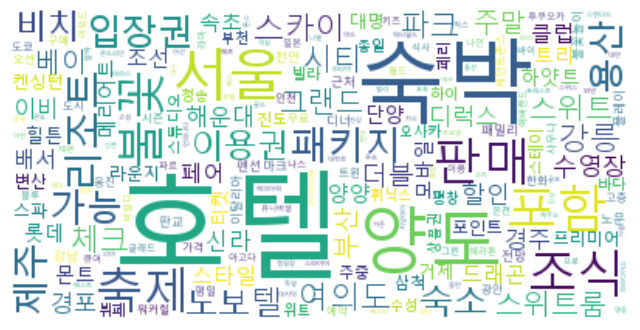

In [211]:
from collections import Counter
from wordcloud import WordCloud

noun_counts = Counter(
    noun for sublist in filter_df['title_nouns'] for noun in sublist 
    if noun not in stopwords and len(noun) > 1 
)

wordcloud = WordCloud(font_path='malgun.ttf', background_color='white').generate_from_frequencies(noun_counts)
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [212]:
noun_counts

Counter({'호텔': 322,
         '숙박': 172,
         '양도': 107,
         '서울': 59,
         '포함': 50,
         '조식': 47,
         '판매': 46,
         '불꽃': 45,
         '축제': 41,
         '리조트': 29,
         '용산': 25,
         '패키지': 24,
         '가능': 23,
         '제주': 22,
         '입장권': 22,
         '숙소': 21,
         '비치': 20,
         '이용권': 20,
         '노보텔': 20,
         '강릉': 18,
         '여의도': 18,
         '스카이': 18,
         '파크': 17,
         '체크': 17,
         '시티': 17,
         '스위트룸': 16,
         '그랜드': 16,
         '스위트': 16,
         '부산': 15,
         '더블': 15,
         '주말': 15,
         '베이': 15,
         '수영장': 14,
         '할인': 14,
         '디럭스': 13,
         '해운대': 13,
         '신라': 13,
         '경주': 13,
         '경포': 13,
         '이비': 13,
         '속초': 12,
         '조선': 12,
         '페어': 12,
         '배서': 12,
         '드래곤': 12,
         '양양': 12,
         '클럽': 12,
         '스타일': 12,
         '트리': 11,
         '몬트': 11,
         '하얏트': 11,
         '롯

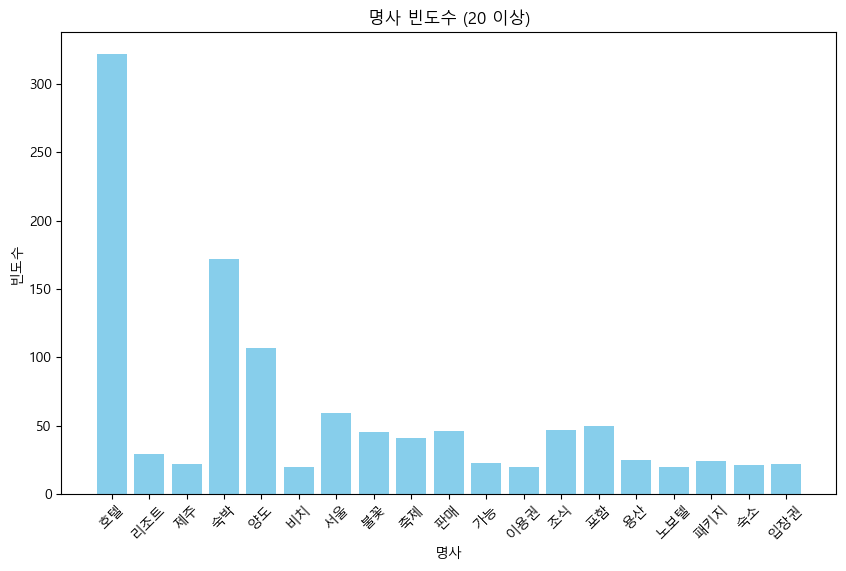

In [213]:
filtered_noun_counts = {noun: count for noun, count in noun_counts.items() if count >= 20}

filtered_df = pd.DataFrame(filtered_noun_counts.items(), columns=['noun', 'count'])
plt.figure(figsize=(10, 6))
plt.bar(filtered_df['noun'], filtered_df['count'], color='skyblue')
plt.title('명사 빈도수 (20 이상)')
plt.xlabel('명사')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()

### 연속형 변수(price, view_count, like_count) 통계치 확인

In [217]:
filter_df[['price','view_count','like_count']].describe()

,price,view_count,like_count
count,5.550000e+02,555.000000,555.000000
mean,3.043628e+05,133.111712,2.518919
std,2.975064e+05,429.148706,8.804183
min,2.000000e+04,0.000000,0.000000
25%,8.000000e+04,5.000000,0.000000
50%,2.000000e+05,19.000000,0.000000
75%,4.000000e+05,79.500000,1.000000
max,2.000000e+06,4899.000000,117.000000


In [218]:
filter_df[['price','view_count','like_count']].corr()

,price,view_count,like_count
price,1.000000,-0.053050,-0.047689
view_count,-0.053050,1.000000,0.894985
like_count,-0.047689,0.894985,1.000000


<Axes: >

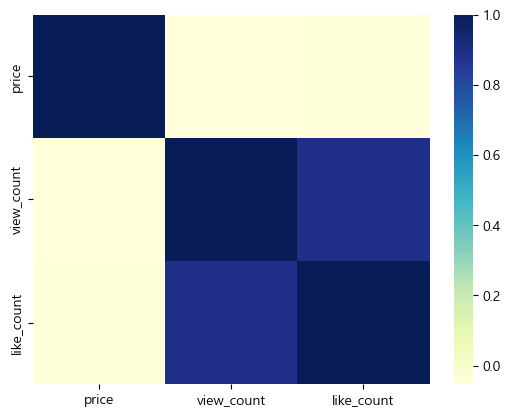

In [219]:
sns.heatmap(filter_df[['price','view_count','like_count']].corr(), cmap="YlGnBu")

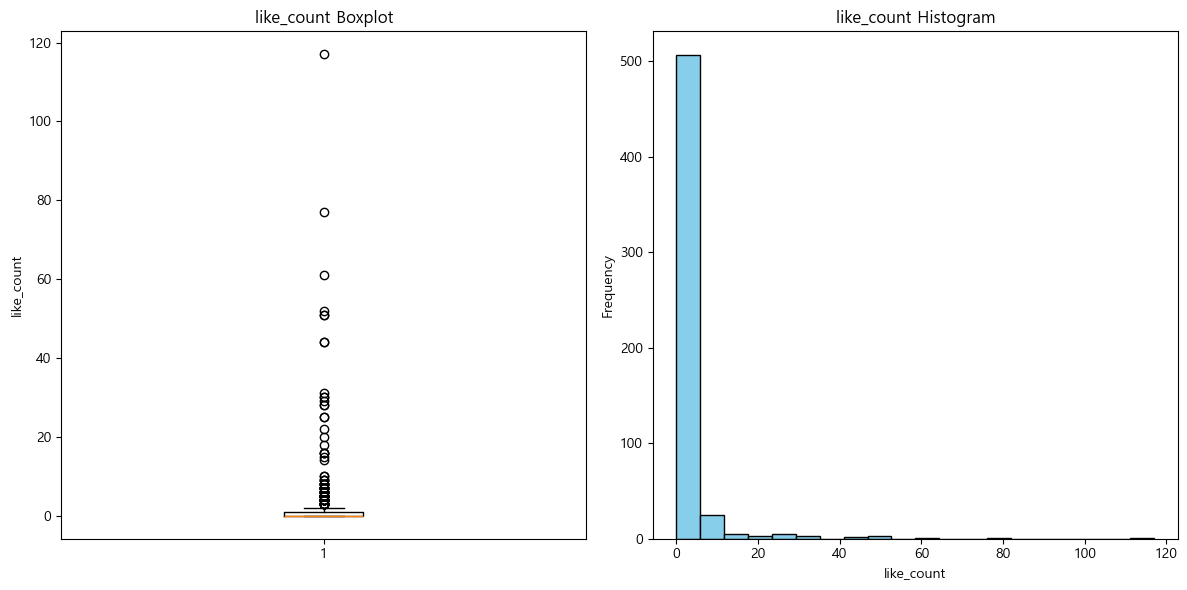

In [223]:
# like_count에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(filter_df['like_count'])
axes[0].set_title('like_count Boxplot')
axes[0].set_ylabel('like_count')

axes[1].hist(filter_df['like_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('like_count Histogram')
axes[1].set_xlabel('like_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

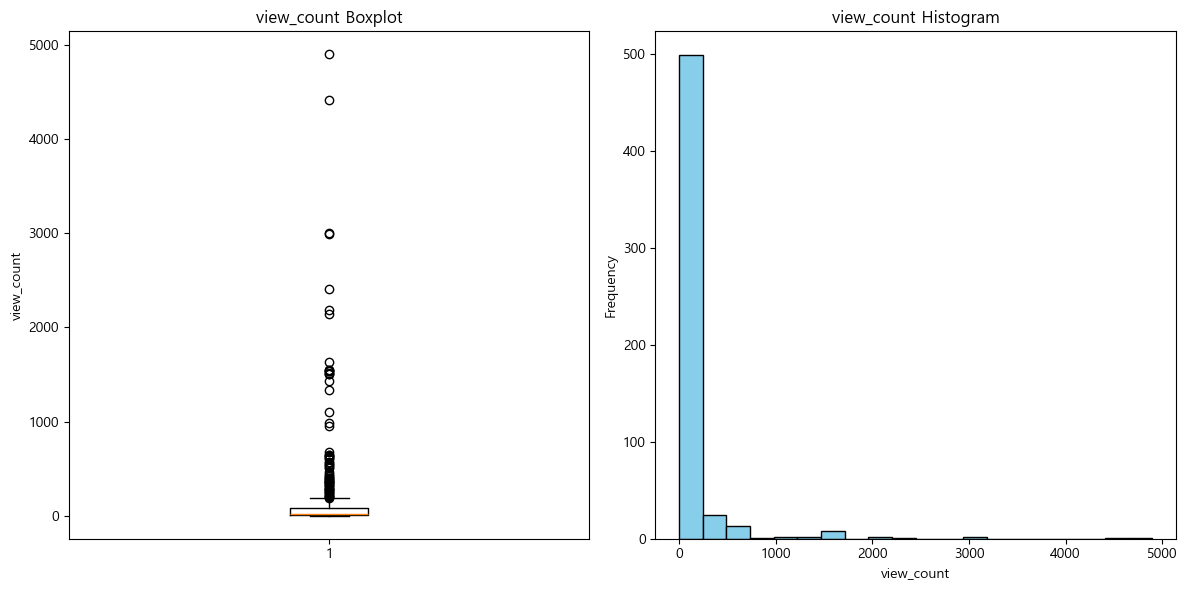

In [221]:
# view_count에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(filter_df['view_count'])
axes[0].set_title('view_count Boxplot')
axes[0].set_ylabel('view_count')

axes[1].hist(filter_df['view_count'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('view_count Histogram')
axes[1].set_xlabel('view_count')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

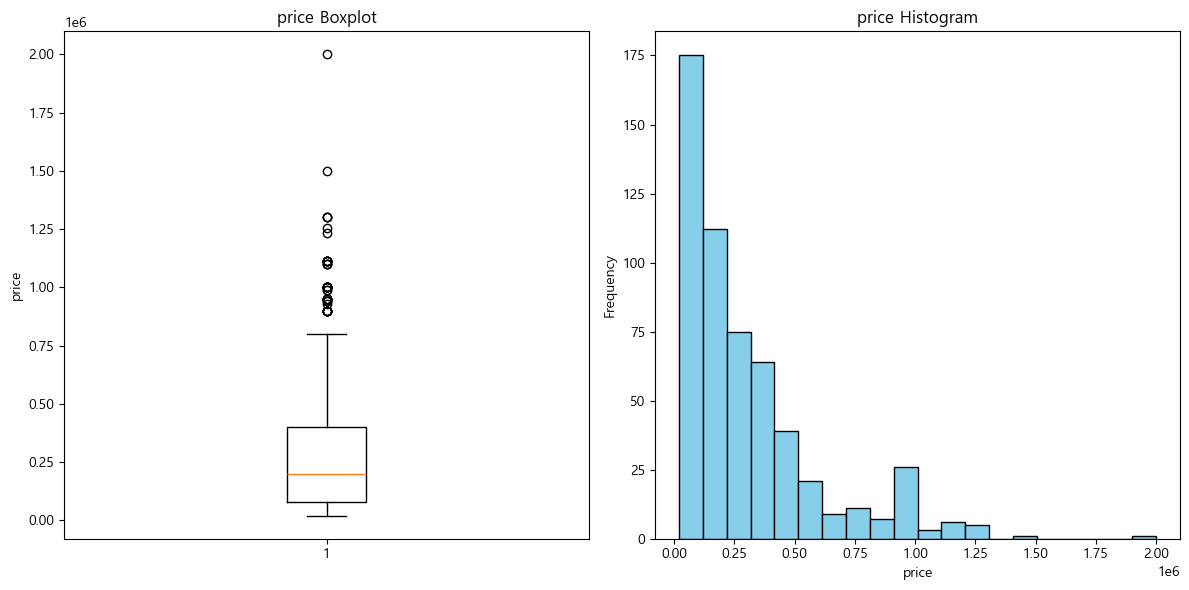

In [222]:
# price에 대한 박스플롯 및 히스토 그램
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 

axes[0].boxplot(filter_df['price'])
axes[0].set_title('price Boxplot')
axes[0].set_ylabel('price')

axes[1].hist(filter_df['price'], bins=20, color='skyblue', edgecolor='black')
axes[1].set_title('price Histogram')
axes[1].set_xlabel('price')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [224]:
filter_df.shape

(555, 13)

### seller_location

In [225]:
filter_df['seller_location'].value_counts()

seller_location
용산구 용산2가동      14
동안구 호계2동        6
성동구 송정동         4
관악구 인헌동         3
강남구 역삼1동        3
               ..
천안시 서북구 백석동     1
서구 청라2동         1
영등포구 당산동        1
대덕구 중리동         1
남양주시 다산2동       1
Name: count, Length: 135, dtype: int64

In [226]:
filter_df['seller_location_1'] = filter_df['seller_location'].apply(lambda x: x.split()[0] if isinstance(x, str) else np.nan)

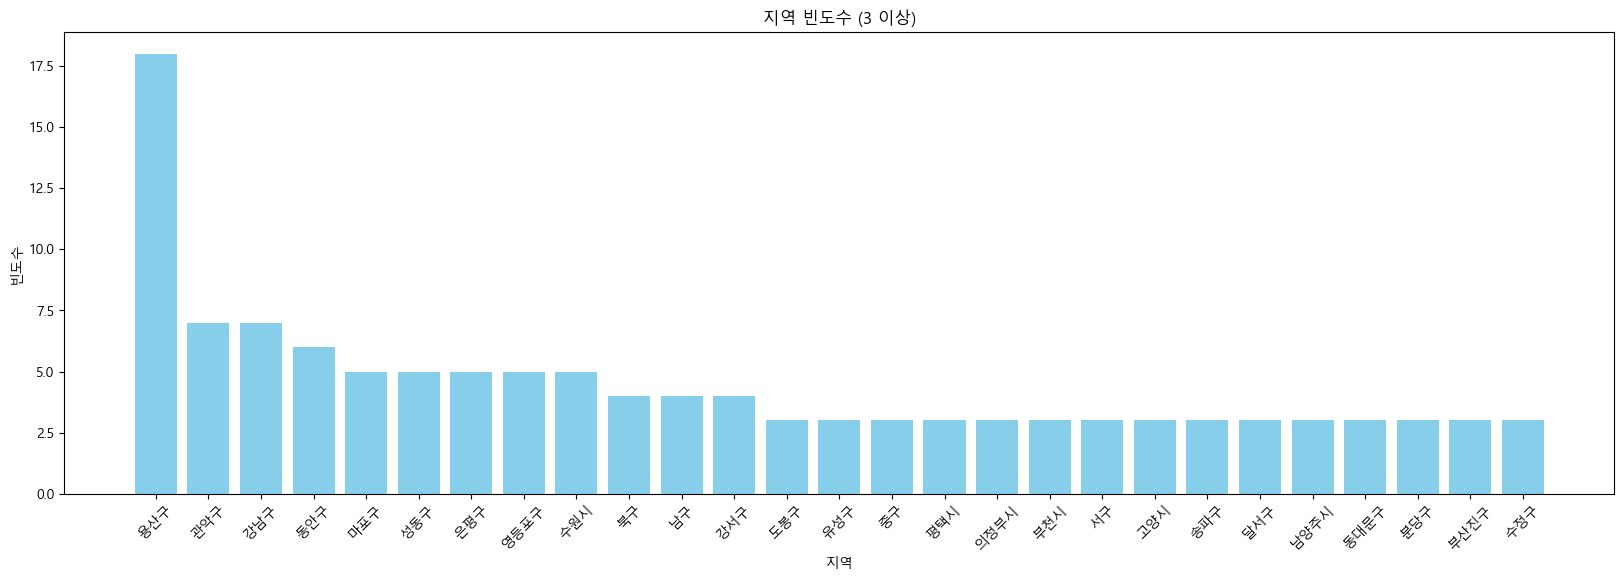

In [227]:
loc_df = pd.DataFrame(filter_df['seller_location_1'].value_counts())

filter_loc_df = loc_df[loc_df['count']>=3]
plt.figure(figsize=(20, 6))
plt.bar(filter_loc_df.index, filter_loc_df['count'], color='skyblue')
plt.title('지역 빈도수 (3 이상)')
plt.xlabel('지역')
plt.ylabel('빈도수')
plt.xticks(rotation=45)
plt.show()

### status

In [228]:
filter_df['status'].value_counts()

status
판매중         130
SELLING     116
판매완료         34
RESERVED      4
Name: count, dtype: int64

In [229]:
filter_df['status'] = filter_df['status'].str.replace('SELLING','판매중').str.replace('RESERVED','예약중')

In [230]:
filter_df['status'].value_counts()

status
판매중     246
판매완료     34
예약중       4
Name: count, dtype: int64

In [254]:
bunjang_df = filter_df[filter_df['platform'] == '번개장터']

In [255]:
bunjang_df[bunjang_df['status'] == '판매완료']['like_count'].mean()

1.0588235294117647

In [257]:
bunjang_df[bunjang_df['status'] == '판매중']['view_count'].mean()

325.4864864864865

In [256]:
bunjang_df[bunjang_df['status'] == '판매완료']['view_count'].mean()

66.41176470588235

### 필터 데이터프레임 저장(pickle_data)

In [240]:
filter_df.to_pickle(os.path.join(data_directory, "filter_df.pickle"))